In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define paths and transformation
#data_dir = 'fire-detection'
data_dir = 'fire_dataset'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.Resize(256),  # Resize shorter side to 256, maintain aspect ratio
    # transforms.CenterCrop((224, 224)),  # Crop to the center
    transforms.ToTensor(),          # Convert images to tensors
    #transforms.Normalize((0.5,), (0.5,))  # Normalize with mean and std
])

In [4]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [5]:
# Separate indices for each class
indices_class_0 = [i for i, (_, label) in enumerate(dataset) if label == 0]
indices_class_1 = [i for i, (_, label) in enumerate(dataset) if label == 1]

In [6]:
# Calculate number of images per split for each class
split_ratios = [0.7, 0.15, 0.15]
class_0_splits = [int(split * len(indices_class_0)) for split in split_ratios]
class_1_splits = [int(split * len(indices_class_1)) for split in split_ratios]

In [24]:
# Split indices for each class
train_indices = indices_class_0[:class_0_splits[0]] + indices_class_1[:class_1_splits[0]]
val_indices = indices_class_0[class_0_splits[0]:class_0_splits[0]+class_0_splits[1]] + \
              indices_class_1[class_1_splits[0]:class_1_splits[0]+class_1_splits[1]]
test_indices = indices_class_0[class_0_splits[0]+class_0_splits[1]:] + \
               indices_class_1[class_1_splits[0]+class_1_splits[1]:]

# Create subsets and dataloaders
batch_size = 32
train_loader = DataLoader(Subset(dataset, train_indices), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(Subset(dataset, val_indices), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(Subset(dataset, test_indices), batch_size=batch_size, shuffle=True)

print("Number of training samples:", len(train_indices))
print("Number of validation samples:", len(val_indices))
print("Number of testing samples:", len(test_indices))

Number of training samples: 698
Number of validation samples: 149
Number of testing samples: 152


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FireDetectionCNN(nn.Module):
    def __init__(self):
        super(FireDetectionCNN, self).__init__()

        # Convolutional Layers with Batch Normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Fully Connected Layers with Dropout and Batch Normalization
        self.fc1 = nn.Linear(56 * 56 * 64, 128)  # Adjusted based on input size and pooling
        self.dropout1 = nn.Dropout(0.5)
        self.bn_fc1 = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.bn_fc2 = nn.BatchNorm1d(64)

        self.fc3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(0.5)

        # Output Layer
        self.fc4 = nn.Linear(32, 1)  # Binary classification, so output is 1
        self.sigmoid = nn.Sigmoid()  # Use sigmoid activation for binary output

    def forward(self, x):
        # First Conv Layer
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        # Second Conv Layer
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        # Flatten the output from conv layers
        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout2(x)

        x = F.relu(self.fc3(x))
        x = self.dropout3(x)

        # Output Layer with Sigmoid Activation
        x = self.sigmoid(self.fc4(x))
        return x


In [9]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in tqdm(range(num_epochs)):
        # Training Phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            # Move data to the device
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).view(-1)  # Ensure the output matches the shape of labels
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).int()  # Convert probability to binary prediction (0 or 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Calculate average training loss and accuracy
        train_loss = running_train_loss / total_train
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                # Move data to the device
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).view(-1)  # Ensure output has the correct shape
                loss = criterion(outputs, labels.float())
                running_val_loss += loss.item() * images.size(0)
                predicted = (outputs > 0.5).int()
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        # Calculate average validation loss and accuracy
        val_loss = running_val_loss / total_val
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Plot Loss and Accuracy over Epochs
    epochs = range(1, num_epochs + 1)
    
    # Plot Loss
    plt.figure()
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure()
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    plt.show()

In [10]:
FireDetectionCNN()

FireDetectionCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (bn_fc1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (bn_fc2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (s

  4%|▍         | 1/25 [00:15<06:00, 15.04s/it]

Epoch [1/25], Train Loss: 0.6447, Train Accuracy: 0.6533, Val Loss: 0.6041, Val Accuracy: 0.8926


  8%|▊         | 2/25 [00:29<05:41, 14.85s/it]

Epoch [2/25], Train Loss: 0.4534, Train Accuracy: 0.9040, Val Loss: 0.3879, Val Accuracy: 0.8859


 12%|█▏        | 3/25 [00:44<05:25, 14.80s/it]

Epoch [3/25], Train Loss: 0.3191, Train Accuracy: 0.9212, Val Loss: 0.3070, Val Accuracy: 0.8792


 16%|█▌        | 4/25 [00:59<05:11, 14.82s/it]

Epoch [4/25], Train Loss: 0.2352, Train Accuracy: 0.9355, Val Loss: 0.1588, Val Accuracy: 0.9530


 20%|██        | 5/25 [01:14<05:02, 15.11s/it]

Epoch [5/25], Train Loss: 0.1780, Train Accuracy: 0.9470, Val Loss: 0.1433, Val Accuracy: 0.9597


 24%|██▍       | 6/25 [01:31<04:54, 15.50s/it]

Epoch [6/25], Train Loss: 0.1650, Train Accuracy: 0.9398, Val Loss: 0.1437, Val Accuracy: 0.9463


 28%|██▊       | 7/25 [01:47<04:40, 15.60s/it]

Epoch [7/25], Train Loss: 0.1676, Train Accuracy: 0.9427, Val Loss: 0.1146, Val Accuracy: 0.9530


 32%|███▏      | 8/25 [02:03<04:31, 15.99s/it]

Epoch [8/25], Train Loss: 0.1537, Train Accuracy: 0.9427, Val Loss: 0.0940, Val Accuracy: 0.9866


 36%|███▌      | 9/25 [02:20<04:19, 16.23s/it]

Epoch [9/25], Train Loss: 0.1669, Train Accuracy: 0.9370, Val Loss: 0.1135, Val Accuracy: 0.9597


 40%|████      | 10/25 [02:37<04:05, 16.40s/it]

Epoch [10/25], Train Loss: 0.1424, Train Accuracy: 0.9527, Val Loss: 0.2811, Val Accuracy: 0.8993


 44%|████▍     | 11/25 [02:54<03:52, 16.63s/it]

Epoch [11/25], Train Loss: 0.1534, Train Accuracy: 0.9427, Val Loss: 0.2954, Val Accuracy: 0.8523


 48%|████▊     | 12/25 [03:11<03:36, 16.64s/it]

Epoch [12/25], Train Loss: 0.1472, Train Accuracy: 0.9456, Val Loss: 0.1376, Val Accuracy: 0.9463


 52%|█████▏    | 13/25 [03:28<03:20, 16.70s/it]

Epoch [13/25], Train Loss: 0.1353, Train Accuracy: 0.9542, Val Loss: 0.1372, Val Accuracy: 0.9463


 56%|█████▌    | 14/25 [03:44<03:03, 16.64s/it]

Epoch [14/25], Train Loss: 0.1608, Train Accuracy: 0.9427, Val Loss: 0.0936, Val Accuracy: 0.9799


 60%|██████    | 15/25 [04:01<02:46, 16.62s/it]

Epoch [15/25], Train Loss: 0.1271, Train Accuracy: 0.9556, Val Loss: 0.1139, Val Accuracy: 0.9597


 64%|██████▍   | 16/25 [04:17<02:29, 16.62s/it]

Epoch [16/25], Train Loss: 0.1292, Train Accuracy: 0.9542, Val Loss: 0.0873, Val Accuracy: 0.9664


 68%|██████▊   | 17/25 [04:34<02:14, 16.81s/it]

Epoch [17/25], Train Loss: 0.1272, Train Accuracy: 0.9613, Val Loss: 0.2915, Val Accuracy: 0.8725


 72%|███████▏  | 18/25 [04:52<01:58, 16.96s/it]

Epoch [18/25], Train Loss: 0.1558, Train Accuracy: 0.9370, Val Loss: 0.1813, Val Accuracy: 0.9463


 76%|███████▌  | 19/25 [05:09<01:41, 17.00s/it]

Epoch [19/25], Train Loss: 0.1652, Train Accuracy: 0.9427, Val Loss: 0.2258, Val Accuracy: 0.8993


 80%|████████  | 20/25 [05:25<01:23, 16.65s/it]

Epoch [20/25], Train Loss: 0.1358, Train Accuracy: 0.9570, Val Loss: 0.1099, Val Accuracy: 0.9799


 84%|████████▍ | 21/25 [05:41<01:05, 16.43s/it]

Epoch [21/25], Train Loss: 0.1323, Train Accuracy: 0.9556, Val Loss: 0.1321, Val Accuracy: 0.9463


 88%|████████▊ | 22/25 [05:57<00:49, 16.36s/it]

Epoch [22/25], Train Loss: 0.1334, Train Accuracy: 0.9441, Val Loss: 0.2356, Val Accuracy: 0.8725


 92%|█████████▏| 23/25 [06:13<00:32, 16.33s/it]

Epoch [23/25], Train Loss: 0.1157, Train Accuracy: 0.9585, Val Loss: 0.1233, Val Accuracy: 0.9732


 96%|█████████▌| 24/25 [06:29<00:16, 16.33s/it]

Epoch [24/25], Train Loss: 0.1420, Train Accuracy: 0.9470, Val Loss: 0.1366, Val Accuracy: 0.9664


100%|██████████| 25/25 [06:46<00:00, 16.25s/it]

Epoch [25/25], Train Loss: 0.1612, Train Accuracy: 0.9398, Val Loss: 0.1597, Val Accuracy: 0.9195


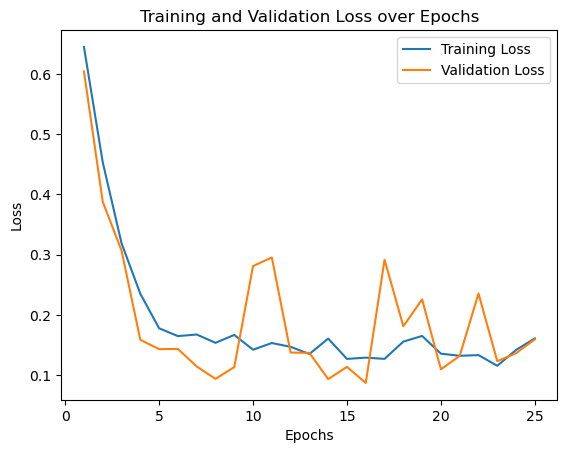

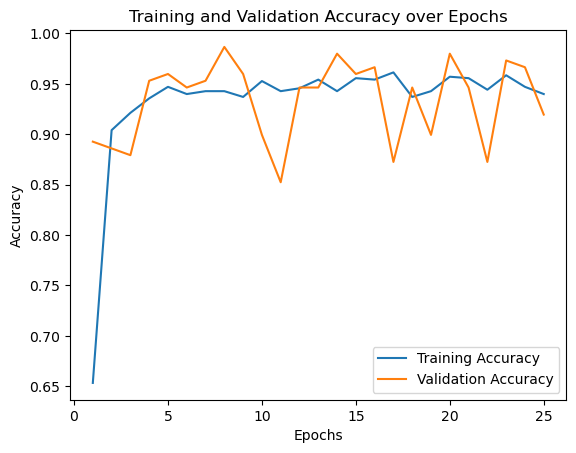

In [11]:
model = FireDetectionCNN().to(device)
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).view(-1)  # Get predictions
            preds = (outputs > 0.5).int()  # Convert probabilities to binary predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Compute metrics
    cm = confusion_matrix(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print("Confusion Matrix:")
    print(cm)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return cm, accuracy, precision, recall, f1

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
cm, acc, prec, rec, f1 = evaluate_model(model, test_loader, device)

Confusion Matrix:
[[113   1]
 [ 11  27]]
Accuracy: 0.9211
Precision: 0.9643
Recall: 0.7105
F1 Score: 0.8182
